<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

Student: Oleg Navolotsky / Олег Наволоцкий  
Stepik: https://stepik.org/users/2403189  
Telegram: [@oleg_navolotsky](https://t.me/oleg_navolotsky)  

**Note**: reproducibility depends on [different things](https://pytorch.org/docs/stable/notes/randomness.html):
>Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

Some used software versions:
- PyTorch 1.8.1
- torchtext 0.9.1
- NumPy 1.19.2
- scikit-learn 0.24.1
- nltk 3.5
- pandas 1.2.3
- matplotlib 3.3.4
- rnnmorph 0.4.0
- Python 3.8.8 (default, Feb 24 2021, 15:54:32) \[MSC v.1928 64 bit (AMD64)] :: Anaconda, Inc. on win32
- NVIDIA Driver 461.33
- NVIDIA CUDA 11.2
- Windows 10 Pro 1909, build 18363.535


Hardware:
- i5 2500 8 gb
- GTX 1060 6 gb
---

In [1]:
import warnings

warnings.filterwarnings("ignore", module="ipykernel", category=DeprecationWarning)

***Some parts of the notebook are almost the exact copy of***  https://github.com/yandexdataschool/nlp_course

##  Attention

Attention layer can take in the previous hidden state of the decoder $s_{t-1}$, and all of the stacked forward and backward hidden states $H$ from the encoder. The layer will output an attention vector $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far $s_{t-1}$, and all of what we have encoded $H$, to produce a vector $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode $\hat{y}_{t+1}$. The decoder input word that has been embedded  $y_t$.

You can use any type of the attention scores between previous hidden state of the encoder $s_{t-1}$ and hidden state of the decoder $h \in H$, you prefer. We have met at least three of them:<br><br>

$$
\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}^{\top} \boldsymbol{s}_{t-1} & \text { dot } \\
\boldsymbol{h}^{\top} \boldsymbol{W}_{\boldsymbol{a}} \boldsymbol{s}_{t-1} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) & \text { concat }
\end{array}\right.
$$
--------


**_We wil use "concat attention"_**:

First, we calculate the *energy* between the previous decoder hidden state $s_{t-1}$ and the encoder hidden states $H$. As our encoder hidden states $H$ are a sequence of $T$ tensors, and our previous decoder hidden state $s_{t-1}$ is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. $\Rightarrow$<br>
We have:<br>
$$H = \bigl[\boldsymbol{h}_{0}, ..., \boldsymbol{h}_{T-1}\bigr] \\ \bigl[\boldsymbol{s}_{t-1}, ..., \boldsymbol{s}_{t-1}\bigr]$$

The encoder hidden dim and the decoder hidden dim should be equal: **dec hid dim = enc hid dim**.<br>
 We then calculate the energy, $E_t$, between them by concatenating them together:<br>

$$\bigl[[\boldsymbol{h}_{0}, \boldsymbol{s}_{t-1}], ..., [\boldsymbol{h}_{T-1}, \boldsymbol{s}_{t-1}]\bigr]$$

And passing them through a linear layer (`attn` = $\boldsymbol{W}_{\boldsymbol{a}}$) and a $\tanh$ activation function:

$$E_t = \tanh(\text{attn}(H, s_{t-1}))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[enc hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, enc hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$


We can think of this as calculating a weighted sum of the "match" over all `enc_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

### Temperature SoftMax

<img src="https://miro.medium.com/max/793/1*S5X1pBq_jfDreJOs7yP-ZQ.png" height=100>

This gives us the attention over the source sentence!

Graphically, this looks something like below. $z = s_{t-1}$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.


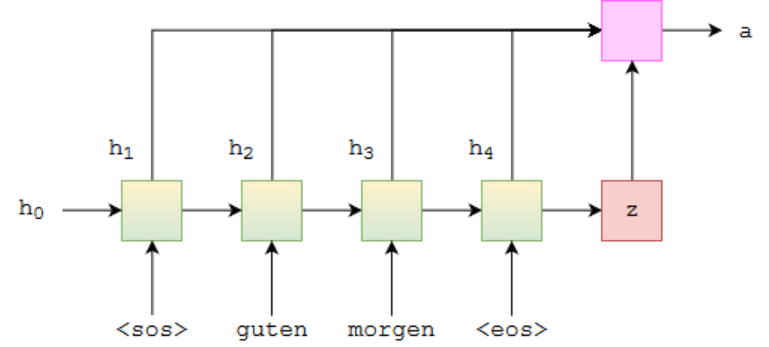

# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [2]:
# !wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# # Thanks to YSDA NLP course team for the data
# # (who thanks tilda and deephack teams for the data in their turn)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

import spacy

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

C:\Users\user0\anaconda3\envs\custom\lib\site-packages\thinc\neural\_custom_kernels.py:36: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\user0\\anaconda3\\envs\\custom\\lib\\site-packages\\thinc\\neural\\_custom_kernels.cu' mode='r' encoding='utf8'>
  SRC = (PWD / "_custom_kernels.cu").open("r", encoding="utf8").read()
C:\Users\user0\anaconda3\envs\custom\lib\site-packages\thinc\neural\_custom_kernels.py:39: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\user0\\anaconda3\\envs\\custom\\lib\\site-packages\\thinc\\neural\\_murmur3.cu' mode='r' encoding='utf8'>
  MMH_SRC = (PWD / "_murmur3.cu").open("r", encoding="utf8").read()
C:\Users\user0\anaconda3\envs\custom\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


We'll set the random seeds for deterministic results.

In [4]:
import os
import random

import numpy as np
import torch


SEED = 1234


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
enable_reproducibility()

## Preparing Data

Here comes the preprocessing

In [6]:
from nltk.tokenize import WordPunctTokenizer

tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
import csv

def raw_text_tuples_iter(path, delimiter='\t', encoding='utf-8'):
    with open(path, encoding=encoding) as file:
        yield from csv.reader(file, delimiter=delimiter)

raw_text_tuples = [(ru, en) for en, ru in raw_text_tuples_iter("data.txt")]

In [8]:
print(len(raw_text_tuples), *raw_text_tuples[0], sep='\n')

50000
Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.
Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.


In [9]:
from torch.utils.data import random_split

def split_data(data, split_sizes=(0.75,)):
    if any(x < 0 for x in split_sizes):
        raise ValueError("split sizes must be non-negative")
    if not 0 < sum(split_sizes) <= 1:
        raise ValueError("split sizes sum must be between 0 (excluding) and 1 (including)")
    data_len = len(data)
    lengths = [round(data_len * size) for size in split_sizes]
    tail_len = data_len - sum(lengths)
    assert tail_len >= 0, (data_len, lengths)
    lengths.append(tail_len)
    splits = random_split(data, lengths=lengths)
    return splits if tail_len else splits[:-1]

In [10]:
enable_reproducibility()
split_ratio = (0.8, 0.15, 0.05)
train_data, valid_data, test_data = split_data(raw_text_tuples, split_ratio)

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


In [11]:
from collections import Counter, namedtuple
from itertools import chain

from torch.utils.data import Dataset
from torchtext.vocab import Vocab

NMTPair = namedtuple("NMTPair", ("src", "trg"))

class NMTDataset(Dataset):
    def __init__(
            self, src_trg_tuples, src_tokenizer, trg_tokenizer,
            src_sos_tok, src_eos_tok,
            trg_sos_tok, trg_eos_tok,
            src_vocab=None, trg_vocab=None,
            src_vocab_kwargs=None, trg_vocab_kwargs=None):
        super().__init__()
        self._src_tokenizer = src_tokenizer
        self._trg_tokenizer = trg_tokenizer
        self._text_tuples = [
            [
                [src_sos_tok] + src_tokenizer(src) + [src_eos_tok], 
                [trg_sos_tok] + trg_tokenizer(trg) + [trg_eos_tok]
            ]
            for src, trg in src_trg_tuples]
        if src_vocab is None:
            counter = Counter(chain.from_iterable(src for src, _ in self._text_tuples))
            if src_vocab_kwargs is None:
                src_vocab_kwargs = {}
            src_vocab = Vocab(counter, **src_vocab_kwargs)
        self.src_vocab = src_vocab
        if trg_vocab is None:
            counter = Counter(chain.from_iterable(trg for _, trg in self._text_tuples))
            if trg_vocab_kwargs is None:
                trg_vocab_kwargs = {}
            trg_vocab = Vocab(counter, **trg_vocab_kwargs)
        self.trg_vocab = trg_vocab
        self._index_tuples = [
            [
                [src_vocab[tok] for tok in src],
                [trg_vocab[tok] for tok in trg]
            ]
            for src, trg in self._text_tuples]

    def __getitem__(self, key):
        return NMTPair(*self._index_tuples[key])

    def __len__(self):
        return len(self._index_tuples)

In [12]:
from torchtext.vocab import Vocab

# UNK_TOK must always be the Vocab.UNK, otherwise vocab["someunknownword"] will return None and
# vocab.stoi["someunknownword"] will raise KeyError, although they both must return index of unk token.
# '<unk>' is hard-coded in the Vocab class, so passing, for example, '<UNK>' leads to aforementioned behavior.
# It is also neccessary for unk token to be passed as 1st of the specials, because vocab["someunknownword"] returns
# index of 1st token from the specials.
# ...and nothing changes: https://github.com/pytorch/text/issues/706
UNK_TOK = Vocab.UNK  

PAD_TOK = '<pad>'
SOS_TOK = '<sos>'
EOS_TOK = '<eos>'
specials = (UNK_TOK, PAD_TOK, SOS_TOK, EOS_TOK)

vocab_kwargs = dict(min_freq=2, specials=specials)

In [13]:
src_sos_tok, src_eos_tok = EOS_TOK, SOS_TOK  # reversed because src sentence reversed
trg_sos_tok, trg_eos_tok = SOS_TOK, EOS_TOK

train_dataset = NMTDataset(
    train_data, tokenize_ru, tokenize_en,
    src_sos_tok, src_eos_tok, trg_sos_tok, trg_eos_tok,
    src_vocab_kwargs=vocab_kwargs, trg_vocab_kwargs=vocab_kwargs)
valid_dataset = NMTDataset(
    valid_data, tokenize_ru, tokenize_en,
    src_sos_tok, src_eos_tok, trg_sos_tok, trg_eos_tok,
    train_dataset.src_vocab, train_dataset.trg_vocab)
test_dataset = NMTDataset(
    test_data, tokenize_ru, tokenize_en,
    src_sos_tok, src_eos_tok, trg_sos_tok, trg_eos_tok,
    train_dataset.src_vocab, train_dataset.trg_vocab)

In [14]:
train_dataset[0]

NMTPair(src=[3, 4, 1839, 77, 10, 12, 165, 5, 7, 1116, 0, 10, 38, 293, 5, 5501, 8, 902, 648, 5, 101, 10447, 8, 1804, 458, 36, 2], trg=[2, 30, 13, 381, 10, 3432, 8, 379, 682, 10, 5088, 9, 284, 38, 12, 3678, 146, 5088, 7, 196, 15, 12, 6, 48, 16, 682, 4, 3])

In [15]:
assert all(train_dataset.src_vocab[tok] == train_dataset.trg_vocab[tok] for tok in specials)
print(train_dataset.src_vocab.itos[:10], train_dataset.trg_vocab.itos[:10])
UNK_IDX = train_dataset.trg_vocab.stoi[PAD_TOK]
PAD_IDX = train_dataset.trg_vocab.stoi[PAD_TOK]
SOS_IDX = train_dataset.trg_vocab.stoi[SOS_TOK]
EOS_IDX = train_dataset.trg_vocab.stoi[EOS_TOK]

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'в', ',', 'и', '-', 'с'] ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'a', 'the', 'and', ',', 'is']


In [16]:
print(f"Unique tokens in source (ru) vocabulary: {len(train_dataset.src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(train_dataset.trg_vocab)}")

Unique tokens in source (ru) vocabulary: 14094
Unique tokens in target (en) vocabulary: 10156


And here is example from train dataset:

In [17]:
def show_sample_tokens(sample: NMTPair, dataset: NMTDataset, sample_raw_data=None):
    if sample_raw_data is not None:
        print("Sample raw data:", sample_raw_data)
    print("Sample:", sample)
    print("Tokens:", {key: [getattr(dataset, key + "_vocab").itos[i] for i in value] for key, value in sample._asdict().items()})

In [18]:
show_sample_tokens(train_dataset[9], train_dataset, train_data[9])

Sample raw data: ('В 20 минутах езды расположен автобусный терминал 1 города Пхукета и пляж Раваи.', 'The property is a 20-minute drive to Phuket Bus Terminal 1 and Rawai Beach.')
Sample: NMTPair(src=[3, 4, 6746, 298, 7, 1727, 37, 50, 2250, 783, 25, 61, 26, 143, 5, 2], trg=[2, 6, 23, 9, 5, 145, 10, 32, 40, 35, 802, 158, 607, 70, 7, 3134, 75, 4, 3])
Tokens: {'src': ['<eos>', '.', 'раваи', 'пляж', 'и', 'пхукета', 'города', '1', 'терминал', 'автобусный', 'расположен', 'езды', 'минутах', '20', 'в', '<sos>'], 'trg': ['<sos>', 'the', 'property', 'is', 'a', '20', '-', 'minute', 'drive', 'to', 'phuket', 'bus', 'terminal', '1', 'and', 'rawai', 'beach', '.', '<eos>']}


When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
import random

from torch.utils.data import DataLoader, Sampler


class MinPadBatchSampler(Sampler):  # mimics BucketIterator in some way, extends it in some sense 
    def __init__(
            self, data_source, batch_size,
            shuffle=False, drop_last=False,
            sort_within_batch=True, sort_key=None,
            *, shuffle_type='batchwise', sort_descending=True, pool_size_factor=100):
        super().__init__(data_source)
        if not hasattr(data_source, '__getitem__'):
            raise TypeError("only map-style datasets supported")
        self.data_source = data_source
        self.batch_size = batch_size
        self._shuffle = shuffle
        self.drop_last = drop_last
        if sort_within_batch and sort_key is None:
            raise ValueError("sort_key must be given when sort_within_batch is True")
        self._sort_key = sort_key
        self._sort_within_batch = sort_within_batch
        if shuffle_type not in ('elementwise', 'batchwise'):
            raise ValueError("shuffle_type must be 'elementwise' or 'batchwise'")
        self._shuffle_type = shuffle_type
        self._sort_descending = sort_descending
        self._pool_size_factor = pool_size_factor
        self._batches_starts = None
    
    def __len__(self):
        if self.drop_last:
            return len(self.data_source) // self.batch_size
        else:
            return (len(self.data_source) + self.batch_size - 1) // self.batch_size

    def _make_batches(self):
        # print("_make_batches")  # TODO: delete
        indices = list(range(len(self.data_source)))
        if self._shuffle and self._shuffle_type == 'elementwise':
            random.shuffle(indices)
        # create pool of indices, sort them within pool
        # to make samples of similar lengths be near
        if self._sort_within_batch:
            all_pools = []
            pool_size = self.batch_size * self._pool_size_factor
            for i in range(0, len(indices), pool_size):
                current_pool = indices[i:i + pool_size]
                current_pool = sorted(
                    current_pool,
                    key=lambda i: self._sort_key(self.data_source[i]),
                    reverse=self._sort_descending
                )
                # print(f"{len(current_pool) = }")  # TODO: delete
                all_pools.extend(current_pool)
        else:
            all_pools = indices
        # split pool into batches of samples with similar lengths
        if self.drop_last:
            incomplete_batch_start = -(len(all_pools) % self.batch_size)
            if incomplete_batch_start < 0:
                del all_pools[incomplete_batch_start:]
        batches_starts = list(range(0, len(all_pools), self.batch_size))
        if self._shuffle and self._shuffle_type == 'batchwise':
            random.shuffle(batches_starts)
        self._pools = all_pools
        self._batches_starts = batches_starts
    
    def __iter__(self):
        # 1st iter() call
        if self._batches_starts is None:  
            self._make_batches()
        # a remake needed because of full reshuffling
        elif self._shuffle and self._shuffle_type == 'elementwise':  
            self._make_batches()
        # just reshuffle previously prepared batches
        elif self._shuffle and self._shuffle_type == 'batchwise':
            random.shuffle(self._batches_starts)
        # yield a mini-batch of indices
        for i in self._batches_starts:
            yield self._pools[i:i + self.batch_size]

In [21]:
# data = list(range(50))
# batch_size_ = 10
# # batch_sampler=MinPadBatchSampler(data, batch_size=10, shuffle=True, drop_last=False, sort_key=lambda x: x, pool_size_factor=4, shuffle_type='elementwise')
# batch_sampler=MinPadBatchSampler(data, batch_size=10, shuffle=True, drop_last=False, sort_within_batch=False, pool_size_factor=1)
# loader = DataLoader(data, batch_sampler=batch_sampler)
# # list(iter(loader))
# len(loader)

In [22]:
# list(iter(loader))

In [23]:
from collections import namedtuple
from torch.nn.utils.rnn import pad_sequence

PaddedBatch = namedtuple("PaddedBatch", ("src", "trg"))
batch_dim_first = False

def collate_fn(batch):
    src = [torch.tensor(src) for src, _ in batch]
    trg = [torch.tensor(trg) for _, trg in batch]
    return PaddedBatch(
        pad_sequence(src, padding_value=PAD_IDX, batch_first=batch_dim_first),
        pad_sequence(trg, padding_value=PAD_IDX, batch_first=batch_dim_first))

In [24]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 48

train_batch_sampler = MinPadBatchSampler(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, sort_key=_len_sort_key)
train_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, collate_fn=collate_fn)

valid_batch_sampler = MinPadBatchSampler(valid_dataset, batch_size=BATCH_SIZE, sort_key=_len_sort_key)
valid_loader = DataLoader(valid_dataset, batch_sampler=valid_batch_sampler, collate_fn=collate_fn)

test_batch_sampler = MinPadBatchSampler(test_dataset, batch_size=BATCH_SIZE, sort_key=_len_sort_key)
test_loader = DataLoader(test_dataset, batch_sampler=test_batch_sampler, collate_fn=collate_fn)

len(train_loader), len(valid_loader), len(test_loader)

(833, 157, 53)

Проверим корректность работы связки `batch_sampler` + `collate_fn`

In [25]:
show_sample_tokens(test_dataset[0], test_dataset, test_data[0])

Sample raw data: ('До Национального музея в Варшаве — 400 метров.', 'The unit is 400 metres from National Museum in Warsaw.')
Sample: NMTPair(src=[3, 4, 172, 381, 47, 6161, 5, 318, 411, 13, 2], trg=[2, 6, 255, 9, 366, 38, 12, 280, 217, 13, 1082, 4, 3])
Tokens: {'src': ['<eos>', '.', 'метров', '400', '—', 'варшаве', 'в', 'музея', 'национального', 'до', '<sos>'], 'trg': ['<sos>', 'the', 'unit', 'is', '400', 'metres', 'from', 'national', 'museum', 'in', 'warsaw', '.', '<eos>']}


In [26]:
not_sorted_test_loader = DataLoader(
    test_dataset,
    batch_sampler=MinPadBatchSampler(
        test_dataset, batch_size=BATCH_SIZE, sort_within_batch=False),
    collate_fn=collate_fn)
batch = next(iter(not_sorted_test_loader))
batch_dim_first = False
if batch_dim_first:
    src, trg = batch.src[0,:], batch.trg[0,:]
else:
    src, trg = batch.src[:, 0], batch.trg[:, 0]
sample = NMTPair(src, trg)
show_sample_tokens(sample, test_dataset, test_data[0])

Sample raw data: ('До Национального музея в Варшаве — 400 метров.', 'The unit is 400 metres from National Museum in Warsaw.')
Sample: NMTPair(src=tensor([   3,    4,  172,  381,   47, 6161,    5,  318,  411,   13,    2,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1]), trg=tensor([   2,    6,  255,    9,  366,   38,   12,  280,  217,   13, 1082,    4,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]))
Tokens: {'src': ['<eos>', '.', 'метров', '400', '—', 'варшаве', 'в', 'музея', 'национального', 'до', '<sos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

In [27]:
batch = next(iter(train_loader))
print("First sample in the sorted batch:")
if batch_dim_first:
    src, trg = batch.src[0,:], batch.trg[0,:]
else:
    src, trg = batch.src[:, 0], batch.trg[:, 0]
sample = NMTPair(src, trg)
show_sample_tokens(sample, train_dataset)
print("\nLast sample in the sorted batch (there might be <pad> in the end of 'src' list):")
if batch_dim_first:
    src, trg = batch.src[-1,:], batch.trg[-1,:]
else:
    src, trg = batch.src[:, -1], batch.trg[:, -1]
sample = NMTPair(src, trg)
show_sample_tokens(sample, train_dataset)

First sample in the sorted batch:
Sample: NMTPair(src=tensor([  3,   4,  12, 459,  35,   0,  37,  13,  34,   2]), trg=tensor([  2,   0,   9, 450,  15,  20,   4,   3,   1,   1,   1,   1,   1,   1,
          1,   1]))
Tokens: {'src': ['<eos>', '.', 'км', '14', 'составляет', '<unk>', 'города', 'до', 'расстояние', '<sos>'], 'trg': ['<sos>', '<unk>', 'is', '14', 'km', 'away', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']}

Last sample in the sorted batch (there might be <pad> in the end of 'src' list):
Sample: NMTPair(src=tensor([   3,    4,  730,   11,   91,   92, 1090,  116,   52,    2]), trg=tensor([  2,  42,  19,  92, 261,  87,  12,  62,  26,   4,   3,   1,   1,   1,
          1,   1]))
Tokens: {'src': ['<eos>', '.', 'реку', 'на', 'вид', 'открывается', 'комнат', 'всех', 'из', '<sos>'], 'trg': ['<sos>', 'you', 'can', 'enjoy', 'river', 'views', 'from', 'all', 'rooms', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']}


In [28]:
# c = next(iter(train_loader))
# a, b = c
# a.shape, b.shape, c

## Let's use modules.py

In [29]:
import modules

## Encoder

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Extending our multi-layer equations to LSTMs, we get:

$$
\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}
$$

<br><br>
<img src="https://drive.google.com/uc?id=1uIUxtZU8NvGdz0J9BlRSTbsBLFh32rxx">

## Attention

$$
\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) \text { - concat attention}
$$

## Decoder with Attention

To make it really work you should also change the `Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer `attention`, which takes the previous hidden state $s_{t-1}$, all of the encoder hidden states $H$, and returns the attention vector $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word that has been embedded $y_t$, the weighted source vector $w_t$, and the previous decoder hidden state $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the **first** word in an example translation.

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block is $z = s_{t-1} = s_0$, the blue block shows the decoder RNN which outputs $s_t = s_1$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

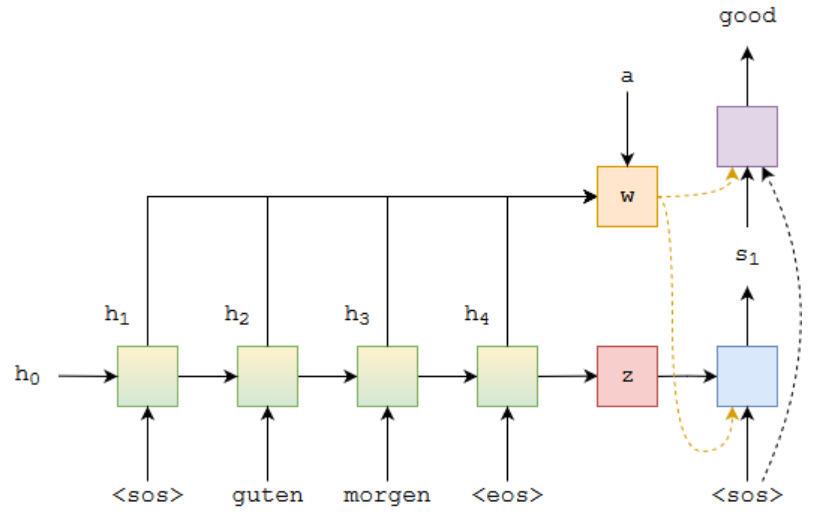

### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.



## Seq2Seq

Main idea:
* $w_t = a_t H$

* $s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$

* $\hat{y}_{t+1} = f(y_t, w_t, s_t)$

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$
\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$
\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$

## Training

In [30]:
for var_name in ('optimizer', 'model', 'dec', 'attention', 'enc', 'lr_scheduler'):
    try:
        del globals()[var_name]
    except KeyError:
        pass
torch.cuda.empty_cache()

In [31]:
# For reloading 
import modules
import importlib
importlib.reload(modules)

Encoder = modules.Encoder
Attention = modules.Attention
Decoder = modules.DecoderWithAttention
Seq2Seq = modules.Seq2Seq

In [32]:
INPUT_DIM = len(train_dataset.src_vocab)
OUTPUT_DIM = len(train_dataset.trg_vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
N_LAYERS = 2
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
BIDIRECTIONAL = True
ENC_OUTPUT_HID_DIM = DEC_HID_DIM = 512
ENC_HID_DIM = DEC_HID_DIM // (BIDIRECTIONAL + 1)

N_EPOCHS = 20
CLIP = 5

TEACHER_FORCING_RATIO = 0.5

enable_reproducibility()
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL, padding_idx=PAD_IDX)
attention = Attention(ENC_OUTPUT_HID_DIM, DEC_HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_OUTPUT_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attention, padding_idx=PAD_IDX)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

In [33]:
def init_weights(m):
    for param in m.parameters():
        nn.init.uniform_(param, -0.08, 0.08)

enable_reproducibility()        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14094, 300, padding_idx=1)
    (rnn): LSTM(300, 256, num_layers=2, dropout=0.8, bidirectional=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=True)
    )
    (embedding): Embedding(10156, 300, padding_idx=1)
    (rnn): GRU(812, 512)
    (out): Linear(in_features=1324, out_features=10156, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,013,493 trainable parameters


In [35]:
enable_reproducibility()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(optimizer, patience=2, verbose=True)


def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg, TEACHER_FORCING_RATIO)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src.to(device)
            trg = batch.trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, OUTPUT_DIM)
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

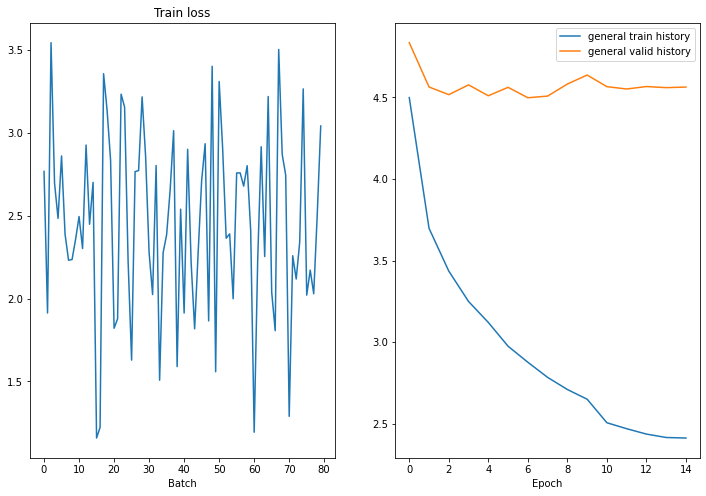

KeyboardInterrupt: 

In [37]:
enable_reproducibility(raise_if_no_deterministic=False)
train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    if lr_scheduler is not None:
        lr_scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [38]:
torch.save(model.state_dict(), 'last-model.pt')

__Let's take a look at our network quality__:

In [39]:
TOKENS_TO_REMOVE = tuple(specials)

def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == EOS_TOK:
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=TOKENS_TO_REMOVE):
    return [x for x in tokens_iter if x not in tokens_to_remove]

@torch.no_grad()
def generate_translation(src, trg, model, trg_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)

    original = remove_tech_tokens(cut_on_eos([trg_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([trg_vocab.itos[x] for x in list(output[:, 0].cpu().numpy())]))
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

def get_text(x, trg_vocab):
     generated = remove_tech_tokens(cut_on_eos([trg_vocab.itos[elem] for elem in list(x)]))
     return generated

# Best val model

In [40]:
model.load_state_dict(torch.load('best-val-model.pt'))
batch = next(iter(test_loader))

for idx in range(10):
    src = batch.src[:, idx:idx+1].to(device)
    trg = batch.trg[:, idx:idx+1].to(device)
    generate_translation(src, trg, model, train_dataset.trg_vocab)

Original: additional room amenities include free wifi , a work area , a chair , flat - screen tv with sky sports , a mini - bar , safe , tea / coffee making facilities , complimentary mineral water , air - conditioning and a modern en - suite bathroom with separate shower and bath .
Generated: the , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv

Original: the guest house is 600 m from dlf city , 1 . 1 km from and 1 . 4 km from road . indira gandhi airport is 7 km away . the bus station is 3 km while the railway station is 4 km .
Generated: the railway station is 1 km from the railway station is 1 km from the railway station is 1 km from the railway station is 1 km from the railway station is 1 km from the railway station is 1 km from the railway station is 1 km from

Original: situated a 5 minutes ' drive from perth , just off the road , bed & bre

## Bleu

[link](https://www.aclweb.org/anthology/P02-1040.pdf)

<img src="https://drive.google.com/uc?id=1umJF2S8PiayxD9Xo8xvjW8QsrSLidozD" height=400>

In [41]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [42]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch.src.to(device)
        trg = batch.trg.to(device)

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].argmax(-1)
        
        original_text.extend([get_text(x, train_dataset.trg_vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, train_dataset.trg_vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

53it [00:06,  8.38it/s]


In [43]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

12.147617666023338

# Last model

In [45]:
model.load_state_dict(torch.load('last-model.pt'))
batch = next(iter(test_loader))

for idx in range(10):
    src = batch.src[:, idx:idx+1].to(device)
    trg = batch.trg[:, idx:idx+1].to(device)
    generate_translation(src, trg, model, train_dataset.trg_vocab)

Original: additional room amenities include free wifi , a work area , a chair , flat - screen tv with sky sports , a mini - bar , safe , tea / coffee making facilities , complimentary mineral water , air - conditioning and a modern en - suite bathroom with separate shower and bath .
Generated: the , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv , a flat - screen tv

Original: the guest house is 600 m from dlf city , 1 . 1 km from and 1 . 4 km from road . indira gandhi airport is 7 km away . the bus station is 3 km while the railway station is 4 km .
Generated: the property is 1 .

Original: situated a 5 minutes ' drive from perth , just off the road , bed & breakfast boasts tranquil accommodation with free wi - fi , free parking , picturesque views , a bright and spacious conservatory , and an outdoor seating area .
Generated: set in a free wi - minute drive from the 

In [46]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch.src.to(device)
        trg = batch.trg.to(device)

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].argmax(-1)
        
        original_text.extend([get_text(x, train_dataset.trg_vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, train_dataset.trg_vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

53it [00:06,  8.65it/s]


In [47]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.18992233310284

## Recommendations:
* use bidirectional RNN
* change learning rate from epoch to epoch
* when classifying the word don't forget about embedding and summa of encoders state 
* you can use more than one layer

## You will get:

* `2` points if `21 < bleu score < 23`
* `4` points if `23 < bleu score < 25`
* `7` points if `25 < bleu score < 27`
* `9` points if `27 < bleu score < 29`
* `10` points if `bleu score > 29`

When your result is checked, your 10 translations will be checked too


## Your Conclusion
* information about your the results obtained 
* difference between seminar and homework model